# Technical indicators

In [503]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ta import momentum, trend, volume
from alpha_vantage.techindicators import TechIndicators
from dotenv import load_dotenv
from datetime import datetime, timedelta
from alpha_vantage import timeseries


load_dotenv()
stock = 'AMD'

key = os.environ["ALPHA_VANTAGE_KEY"]


## Load data from file or create new file

In [504]:
try:
    df = pd.read_csv(f"{stock}.csv", index_col=0, parse_dates=[0])
    latest_timestamp = datetime.fromtimestamp(df.index[0].timestamp()).date()
    yesterday = datetime.now().date() - timedelta(days=1)
    if latest_timestamp != yesterday:
        raise Exception
except Exception:
    key = os.environ["ALPHA_VANTAGE_KEY"]
    ts = timeseries.TimeSeries(key=key, output_format="pandas")
    df, _ = ts.get_daily_adjusted(symbol=stock, outputsize="full")
    df.to_csv(f"{stock}.csv")

In [505]:
date_range = "2020-01-01"
df_recent = df[df.index > date_range]

## SMA - Simple Moving Average

In [506]:
def get_sma(close, window=12, fillna=False):
    return trend.sma_indicator(close=close, window=window, fillna=fillna)

# Reverse the dataset to put in the oldest values first
sma = get_sma(df['5. adjusted close'][::-1])

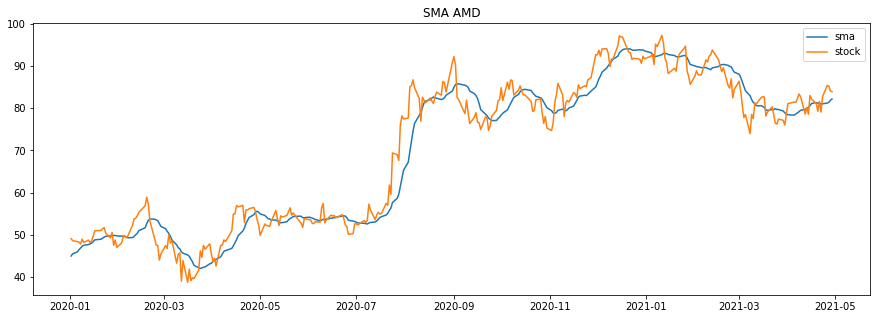

In [507]:
# Plot
sma_recent = sma[sma.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(sma_recent.index, sma_recent, label="sma")
plt.plot(df_recent.index, df_recent['5. adjusted close'], label="stock")
plt.legend()
plt.title(f"SMA {stock}")
plt.show()

## EMA - Exponential Moving Average

In [508]:
def get_ema(close, window=12, fillna=False):
    return trend.ema_indicator(close=close, window=window, fillna=fillna)


# Reverse the dataset to put in the oldest values first
ema = get_ema(df['5. adjusted close'][::-1])

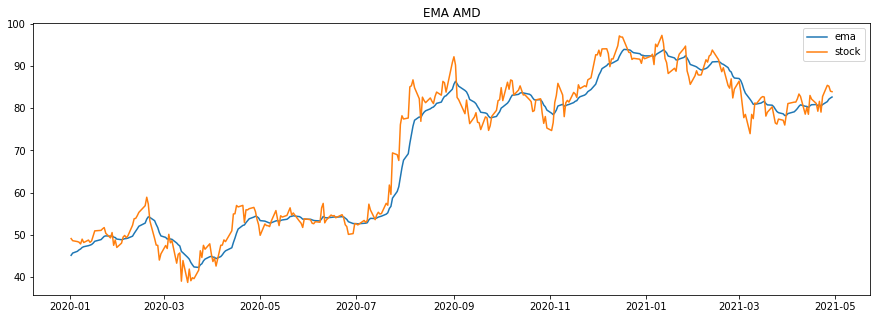

In [509]:
# Plot
ema_recent = ema[ema.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(ema_recent.index, ema_recent, label='ema')
plt.plot(df_recent.index, df_recent['5. adjusted close'], label="stock")
plt.legend()
plt.title(f"EMA {stock}")
plt.show()

## ROC - Rate of Change

In [510]:
def get_roc(close, window=12, fillna=False):
    return momentum.roc(close, window=window, fillna=False)


roc = get_roc(df['5. adjusted close'][::-1])

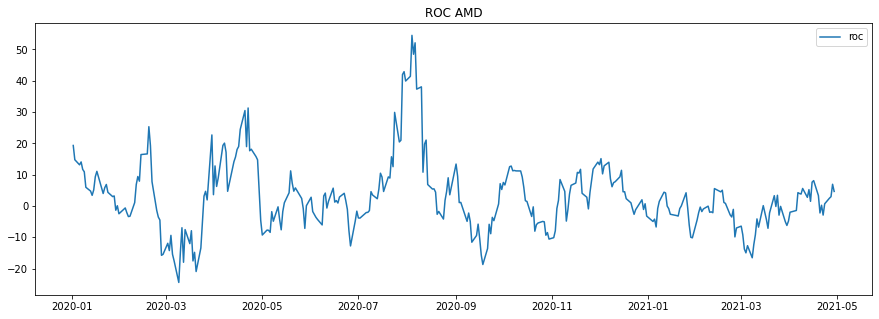

In [511]:
# Plot 
roc_recent = roc[roc.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(roc_recent.index, roc_recent, label='roc')
plt.legend()
plt.title(f"ROC {stock}")
plt.show()

## RSI - Relative Strength Indicator
> 70 = Overbought
< 30 = Oversold

In [512]:
def get_rsi(close, window=14, fillna=False):
    return momentum.rsi(close, window=window, fillna=False)

rsi = get_rsi(df['5. adjusted close'][::-1])

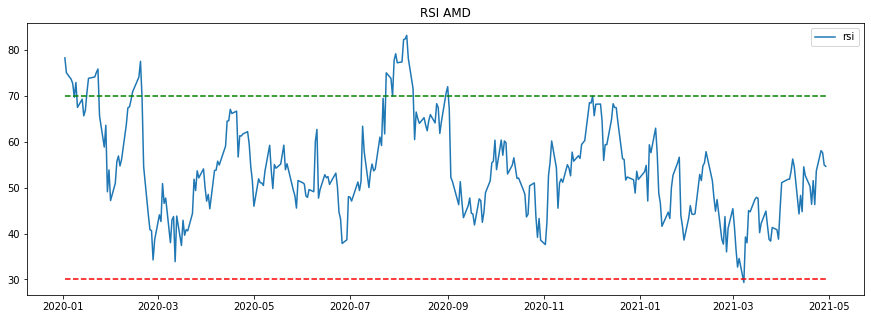

In [513]:
# Plot
rsi_recent = rsi[rsi.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(rsi_recent.index, rsi_recent, label='rsi')
plt.plot(rsi_recent.index, np.full((rsi_recent.size),70), "g--")
plt.plot(rsi_recent.index, np.full((rsi_recent.size),30), "r--")
# plt.plot(df.index, df['5. adjusted close'], label="stock")
plt.legend()
plt.title(f"RSI {stock}")
plt.show()

## OBV - On-Balance Volume

In [514]:
def get_obv(close, volume_input, fillna=False):
    return volume.on_balance_volume(close=close, volume=volume_input, fillna=False)

obv = get_obv(close=df['5. adjusted close'][::-1],volume_input=df['6. volume'][::-1])

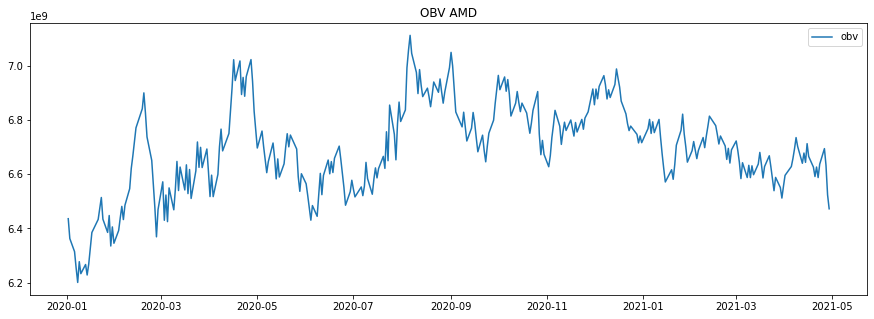

In [515]:
# Plot
obv_recent = obv[obv.index > date_range]

plt.figure(figsize=(15,5))
plt.plot(obv_recent.index, obv_recent, label='obv')
plt.legend()
plt.title(f"OBV {stock}")
plt.show()

## Define comparison methods

In [516]:
def prepare_indicator(local_indicator, name, decimals):
    if not isinstance(local_indicator, pd.DataFrame):
        local_indicator = local_indicator.to_frame()
    local_indicator.rename(columns={f"{local_indicator.columns[0]}": f"{name}"}, inplace=True)
    local_indicator = local_indicator.round(decimals=decimals)
    local_indicator = local_indicator.dropna()
    return local_indicator


def calc_difference(local_indicator, av_indicator):
    difference= local_indicator.compare(av_indicator)
    if difference.size > 0:
        columns = difference.columns
        overall_difference = sum(abs(difference[columns[0]] - difference[columns[1]]))
        print(f"Overall difference in Alphavantage vs. local calculation: {overall_difference}")
    else:
        print("The data sets are identical")

In [517]:
ti = TechIndicators(key=key, output_format="pandas")

## Compare calculated SMA to Alphavantage SMA

In [518]:
sma_av, _ = ti.get_sma(symbol=stock, interval="daily", time_period=12, series_type="close")

In [519]:
sma = prepare_indicator(local_indicator=sma, name=f"{sma_av.columns[0]}", decimals=4)
calc_difference(local_indicator=sma, av_indicator=sma_av)

Overall difference in Alphavantage vs. local calculation: 0.005500000000019378


## Compare calculated EMA to Alphavantage EMA

In [520]:
ema_av, _ = ti.get_ema(symbol=stock, interval="daily", time_period=12,series_type="close")

In [521]:
ema = prepare_indicator(local_indicator=ema, name=f"{ema_av.columns[0]}", decimals=4)
calc_difference(local_indicator=ema, av_indicator=ema_av)

Overall difference in Alphavantage vs. local calculation: 2.309799999999999


## Compare calculated ROC to Alphavantage ROC

In [522]:
roc_av, _ = ti.get_roc(symbol=stock, interval="daily", time_period=12,series_type="close")

In [523]:
roc = prepare_indicator(local_indicator=roc, name=f"{roc_av.columns[0]}", decimals=4)
calc_difference(local_indicator=roc, av_indicator=roc_av)

Overall difference in Alphavantage vs. local calculation: 0.00010000000000331966


## Compare calculated RSI to Alphavantage RSI

In [524]:
rsi_av, _ = ti.get_rsi(symbol=stock, interval="daily", time_period=14,series_type="close")

In [525]:
print(len(rsi.index))
print(len(rsi_av.index))

5408
5394


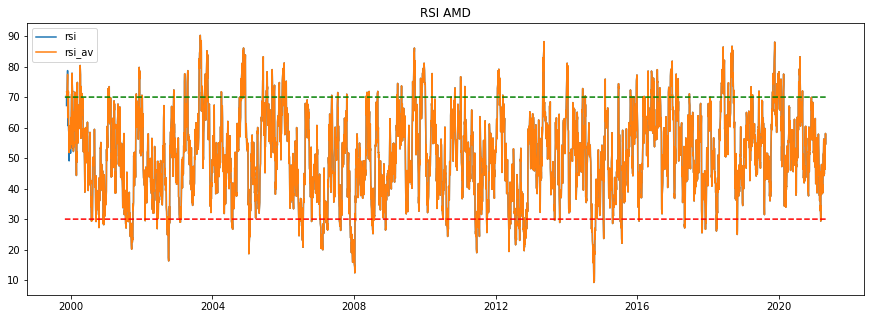

In [526]:
# Plot every 50th item
plt.figure(figsize=(15,5))
plt.plot(rsi.index, rsi, label='rsi')
plt.plot(rsi_av.index, rsi_av, label='rsi_av')
plt.plot(rsi.index, np.full((rsi.size),70), "g--")
plt.plot(rsi.index, np.full((rsi.size),30), "r--")
plt.legend()
plt.title(f"RSI {stock}")
plt.show()

In [527]:
rsi = prepare_indicator(local_indicator=rsi, name=f"{rsi_av.columns[0]}", decimals=4)
rsi
# calc_difference(local_indicator=rsi, av_indicator=rsi_av)

,RSI
date,
1999-11-18,67.2227
1999-11-19,70.7598
1999-11-22,69.4036
1999-11-23,68.4371
1999-11-24,69.9618
...,...
2021-04-23,53.6586
2021-04-26,58.0811
2021-04-27,57.6341
